In [1]:
import igl
import pymesh
import scipy as sp
import numpy as np
from meshplot import plot, subplot, interact
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from sklearn.decomposition import PCA
import os
from os.path import join as pjoin

import registration.utils

In [38]:
#mesh1 = pymesh.form_mesh(v1, f1)
mesh1 = pymesh.load_mesh(pjoin("../data/ctkDICOM-Database/demo1", "Segmentation_11_26.stl"))
mesh2 = pymesh.load_mesh(pjoin("../data/ctkDICOM-Database/demo1", "Segmentation_11_27.stl"))
mesh1.enable_connectivity()
mesh1.get_vertex_adjacent_vertices(5)

array([ 0,  1,  4,  8,  9, 13, 14, 21], dtype=int32)

In [39]:
def fix_mesh(mesh, detail="normal", max_vertices=20000):
    bbox_min, bbox_max = mesh.bbox
    diag_len = np.linalg.norm(bbox_max - bbox_min)
    if type(detail) == str:
        if detail == "normal":
            target_len = diag_len * 5e-3
        elif detail == "high":
            target_len = diag_len * 2.5e-3
        elif detail == "low":
            target_len = diag_len * 1e-2
    else:
        target_len = detail
    print("Target resolution: {} mm".format(target_len))
    
    tol = 0.01
    mesh, info = pymesh.remove_duplicated_vertices(mesh, target_len * tol)
    print(info)

    count = 0
    mesh, __ = pymesh.remove_degenerated_triangles(mesh, 100)
    mesh, __ = pymesh.split_long_edges(mesh, target_len)
    num_vertices = mesh.num_vertices
    while True:
        mesh, __ = pymesh.collapse_short_edges(mesh, 1e-6)
        mesh, __ = pymesh.collapse_short_edges(mesh, target_len,
                                               preserve_feature=True)
        mesh, __ = pymesh.remove_obtuse_triangles(mesh, 150.0, 100)
        if mesh.num_vertices == num_vertices or mesh.num_vertices > max_vertices:
            break

        num_vertices = mesh.num_vertices
        print("#v: {}".format(num_vertices))
        count += 1
        if count > 10: break

    mesh = pymesh.resolve_self_intersection(mesh)
    mesh, __ = pymesh.remove_duplicated_faces(mesh)
    mesh = pymesh.compute_outer_hull(mesh)
    mesh, __ = pymesh.remove_duplicated_faces(mesh)
    mesh, __ = pymesh.remove_obtuse_triangles(mesh, 179.0, 5)
    mesh, __ = pymesh.remove_isolated_vertices(mesh)

    return mesh

In [40]:
mesh1 = fix_mesh(mesh1, 0.2)
mesh2 = fix_mesh(mesh2, 0.2)

Target resolution: 0.2 mm
{'num_vertex_merged': 15, 'index_map': array([   0,    1,    2, ..., 7674, 7675, 7676], dtype=int32)}
#v: 9835
#v: 9815
Target resolution: 0.2 mm
{'num_vertex_merged': 5, 'index_map': array([   0,    1,    2, ..., 6368, 6369, 6370], dtype=int32)}
#v: 8523
#v: 8512


In [41]:
plot(mesh1.vertices, mesh1.faces, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(86.933238…

# PCA as a way to get relative axes

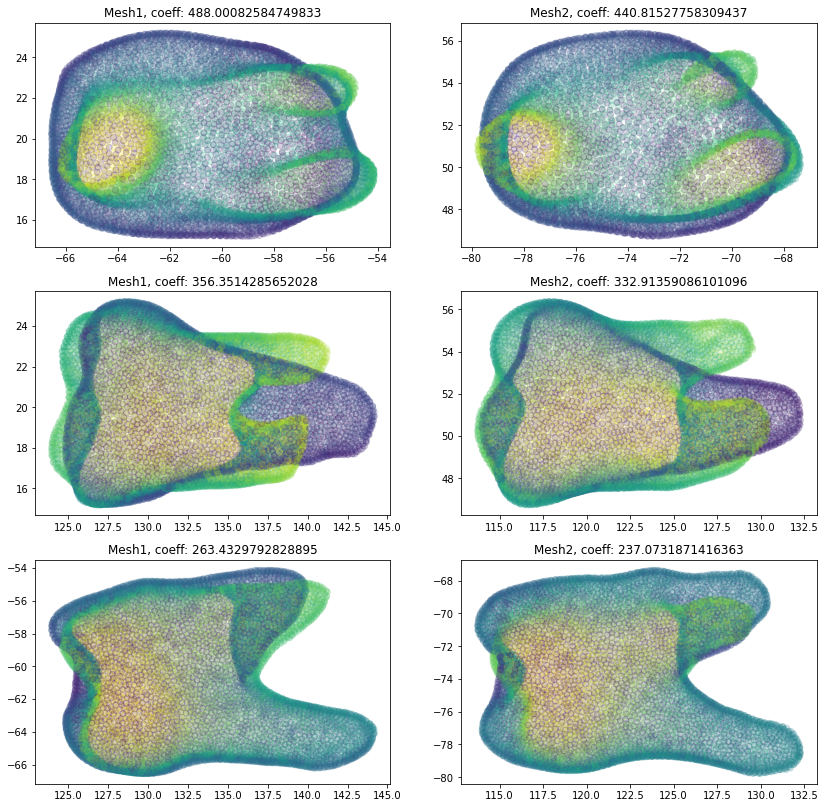

In [42]:
pca = PCA(3)
pca.fit(mesh1.vertices)
pca.components_

p1_0 = mesh1.vertices @ pca.components_[[1,2]].T
d1_0 = mesh1.vertices @ pca.components_[0]
p1_1 = mesh1.vertices @ pca.components_[[0,2]].T
d1_1 = mesh1.vertices @ pca.components_[1]
p1_2 = mesh1.vertices @ pca.components_[[0,1]].T
d1_2 = mesh1.vertices @ pca.components_[2]

pca2 = PCA(3)
pca2.fit(mesh2.vertices)
pca2.components_

p2_0 = mesh2.vertices @ pca2.components_[[1,2]].T
d2_0 = mesh2.vertices @ pca2.components_[0]
p2_1 = mesh2.vertices @ pca2.components_[[0,2]].T
d2_1 = mesh2.vertices @ pca2.components_[1]
p2_2 = mesh2.vertices @ pca2.components_[[0,1]].T
d2_2 = mesh2.vertices @ pca2.components_[2]

f, axarr = plt.subplots(3, 2, figsize = (14,14))
axarr[0,0].set_title("Mesh1, coeff: {}".format(pca.singular_values_[0]))
axarr[0,0].scatter(p1_0[:,0],p1_0[:,1], c=d1_0, alpha=0.2)
axarr[1,0].set_title("Mesh1, coeff: {}".format(pca.singular_values_[1]))
axarr[1,0].scatter(p1_1[:,0],p1_1[:,1], c=d1_1, alpha=0.2)
axarr[2,0].set_title("Mesh1, coeff: {}".format(pca.singular_values_[2]))
axarr[2,0].scatter(p1_2[:,0],p1_2[:,1], c=d1_2, alpha=0.2)

axarr[0,1].set_title("Mesh2, coeff: {}".format(pca2.singular_values_[0]))
axarr[0,1].scatter(p2_0[:,0],p2_0[:,1], c=d2_0, alpha=0.2)
axarr[1,1].set_title("Mesh2, coeff: {}".format(pca2.singular_values_[1]))
axarr[1,1].scatter(p2_1[:,0],p2_1[:,1], c=d2_1, alpha=0.2)
axarr[2,1].set_title("Mesh2, coeff: {}".format(pca2.singular_values_[2]))
axarr[2,1].scatter(p2_2[:,0],p2_2[:,1], c=d2_2, alpha=0.2)

We can see that the projection of the teeth on  the 3 first PCA components shows us the same axis of the teeth.

In [43]:
norm_axis1 = pca.components_ / np.linalg.norm(pca.components_, axis=1)
norm_axis2 = pca2.components_ / np.linalg.norm(pca2.components_, axis=1)
R_pca = np.einsum("ij,ik->ijk", norm_axis1, norm_axis2).sum(0) #Rotation as in https://math.stackexchange.com/questions/1125203/finding-rotation-axis-and-angle-to-align-two-3d-vector-bases
S_pca = np.sqrt(pca2.singular_values_ / pca.singular_values_) #scale
T_pca = pca2.mean_ - pca.mean_ @ R_pca * S_pca #Translation

In [44]:
aligned_mesh1 = pymesh.form_mesh(mesh1.vertices @ R_pca * S_pca  + T_pca, mesh1.faces)

p = plot(mesh2.vertices, mesh2.faces, shading={"wireframe": True})
p.add_mesh(aligned_mesh1.vertices, mesh1.faces, c=np.array([(0.7,0.7,0.7)]*aligned_mesh1.num_vertices), shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(86.290672…

1

# Trying to get automated landmarks

In [45]:
mesh1.add_attribute("vertex_mean_curvature")
mesh1.add_attribute("vertex_gaussian_curvature")
mesh1.add_attribute("vertex_area")
k = mesh1.get_attribute("vertex_mean_curvature")


p = plot(mesh1.vertices, mesh1.faces, c=k>0.5, shading={"wireframe": True})
p = plot(mesh1.vertices, mesh1.faces, c=d1_0, shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(86.933238…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(86.933238…

In [46]:
def topk(x,k):
    return x.argsort()[-k:][::-1]

In [47]:
dist = 1.5
idx_concave = np.where(k > 0.5)[0]# topk(k,200)
#idx_convex = topk(-k,100)
#idx = np.concatenate([idx_concave[(np.abs(mesh1.vertices[idx_concave, 2] - mesh1.vertices[:,2].min()) < dist) | (np.abs(mesh1.vertices[idx_convex, 2] - mesh1.vertices[:,2].max()) < dist)],
#                     idx_convex[np.abs(mesh1.vertices[idx_convex, 2] - mesh1.vertices[:,2].max()) < dist]])
proj = mesh1.vertices @ pca.components_[0]
idx = idx_concave[(np.abs(proj[idx_concave] - proj.min()) < dist) | (np.abs(proj[idx_concave] - proj.max()) < dist)]

def filter_number(idx, vertices):
    d = 1.
    tree = KDTree(vertices[idx])
    inside_ball = tree.query_radius(vertices[idx], d)
    number = np.array(list(map(len, inside_ball)))
    return idx[number > 10]

idx = filter_number(idx, mesh1.vertices)

p = plot(mesh1.vertices, mesh1.faces, c=k, shading={"wireframe": True})
p.add_points(mesh1.vertices[idx], c=proj[idx], shading={"point_size": 4})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(86.933238…

1

In [48]:
def compute_laplacian(V, F):
    """
    Compute the Laplacian of the mesh
    
    args:
        V: (N x 3) a numpy array of vertices' positions    ex: [ (x0,y0,z0), (x1,y1,z1) ...]
        F: (M x 3) a numpy array of the faces of the triangular mesh (by vertex id) ex: [ (0,1,4), (2,4,5), ...]
    return:
        L: sparce_csr(N x N) the Laplacian matrix with cotangent weights
    """
    n = len(V)
    W_ij = np.empty(0)
    I = np.empty(0, np.int32)
    J = np.empty(0, np.int32)
    for i1, i2, i3 in [(0, 1, 2), (1, 2, 0), (2, 0, 1)]:
        vi1 = F[:, i1]
        vi2 = F[:, i2]
        vi3 = F[:, i3]
        u = V[vi2] - V[vi1]
        v = V[vi3] - V[vi1]

        cotan = (u * v).sum(axis=1) / np.linalg.norm(np.cross(u, v), -1)
        W_ij = np.append(W_ij, 0.5 * cotan)
        I = np.append(I, vi2)
        J = np.append(J, vi3)
        W_ij = np.append(W_ij, 0.5 * cotan)
        I = np.append(I, vi3)
        J = np.append(J, vi2)
    L = sp.sparse.csr_matrix((W_ij, (I, J)), shape=(n, n))
    L = L - sp.sparse.spdiags(L * np.ones(n), 0, n, n)
    L = L.tocsr()
    return L

In [51]:
L = compute_laplacian(mesh1.vertices, mesh1.faces)
evals, evecs = sp.sparse.linalg.eigsh(L, k=6)

In [52]:
L1 = -igl.cotmatrix(mesh1.vertices, mesh1.faces)
evals, evecs = sp.sparse.linalg.eigsh(L, k=6)
#evecs = (evecs-np.percentile(evecs, 5))/(np.percentile(evecs, 95)-np.percentile(evecs, 5))
#evecs = np.clip(evecs, 0, 1)

In [53]:
L1

<8947x8947 sparse matrix of type '<class 'numpy.float64'>'
	with 62617 stored elements in Compressed Sparse Column format>

In [54]:
L.min()

-0.0011220557713933555

In [56]:
for i in range(6):
    plot(mesh1.vertices, mesh1.faces, c=np.array(evecs.T[i] > 0), shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(86.933238…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(86.933238…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(86.933238…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(86.933238…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(86.933238…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(86.933238…

# Using ICL to rigidly match the teeth after a first PCA alignment

In [57]:
R, T = igl.iterative_closest_point(aligned_mesh1.vertices, mesh1.faces, mesh2.vertices, mesh2.faces, num_samples=8000, max_iters=100)

In [58]:
final_aligned_mesh1 = pymesh.form_mesh(aligned_mesh1.vertices @ R + T, mesh1.faces)

p = plot(mesh2.vertices, mesh2.faces, shading={"wireframe": True})
p.add_mesh(final_aligned_mesh1.vertices, mesh1.faces, c=np.array([(0.7,0.7,0.7)]*aligned_mesh1.num_vertices), shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(86.290672…

1

# If you want to rotate along one axis

In [59]:
from scipy.linalg import expm
def Rot(axis, theta):
    return expm(np.cross(np.eye(3), axis/np.linalg.norm(axis)*np.pi*theta/180))

axis = PCA(3).fit(final_aligned_mesh1.vertices).components_[0]
center = PCA(3).fit(final_aligned_mesh1.vertices).mean_
R2 = Rot(axis, 180)

p = plot(mesh2.vertices, mesh2.faces, shading={"wireframe": True})
p.add_mesh((final_aligned_mesh1.vertices - center) @ R2 + center, mesh1.faces, c=np.array([(0.7,0.7,0.7)]*aligned_mesh1.num_vertices), shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(86.290672…

1

I'm pretty sure we should look at SIFt features on 3D meshes:
http://yosi-keller.narod.ru/publications/pdf/mesh_descriptors_two_columns_final.pdf
and the code :
https://github.com/talda/ldsift

This allow to find landmarks so we could do rigid transformation with landmarks + use it after for non-rigid transformation

# Non-rigid deformation using optimization of a cost function

In [60]:
def check_angle(vec1,vec2,threshAngle):
    if (len(vec1) == 0 or len(vec2) == 0):
        return np.ones((vec2.shape[0],1))

    crossProd = np.cross(vec1,vec2,1)
    dotProd = np.sum((vec1*vec2),1)
    angle = np.arctan2((np.sum((crossProd**2),1))**0.5, dotProd)/np.pi*180

    angle = angle%360

    return angle <= threshAngle

In [61]:
def cost_fun(A, M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min, angle_max=60):
    N = M.num_vertices
    A = A.reshape(3,4,N)
    
    #if AM is None:
    AM = pymesh.form_mesh(np.einsum("ijk,jk->ki",A, M.vertices.T), M.faces)
    #if (dist is None and is_valid_nn is None) or NN_M2S is None:
    tree = KDTree(S.vertices, leaf_size=40)
    dist, NN_M2S = tree.query(AM.vertices,1)
    NN_M2S = NN_M2S.flatten()
    dist = dist.flatten()
    #if is_valid_nn is None:
    AMn = igl.per_vertex_normals(AM.vertices, M.faces)
    Sn = igl.per_vertex_normals(S.vertices, S.faces)
    is_valid_nn = check_angle(AMn, Sn[NN_M2S], angle_max) & (dist <= dist_min)
    #is_valid_nn = np.array([True]*len(dist))

    E_smooth = 0
    nSmooth = 0
    for i in range(N):
        ring = M.get_vertex_adjacent_vertices(i)
        E_smooth += (np.linalg.norm(A[:,:,i:i+1] - A[:,:,ring])**2).sum()
        nSmooth += len(ring)
    E_smooth *= W_smooth/nSmooth

    if W_data > 0 and np.sum(is_valid_nn) > 0:
        E_data = (is_valid_nn/np.sum(is_valid_nn) * np.linalg.norm(AM.vertices - S.vertices[NN_M2S])**2).sum()
    else:
        E_data = 0.

    E_lm = (np.linalg.norm(np.einsum("ijk,jk->ki",A[:,:,landmarks_M], M.vertices[landmarks_M].T) - S.vertices[landmarks_S])**2).sum()
    if (len(landmarks_M) > 0):
        E_lm *= W_lm/len(landmarks_M)

    E_total = E_data + E_smooth + E_lm

    return E_total

def grad_cost_fun(A, M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min, angle_max=60):
    N = M.num_vertices
    A = A.reshape(3,4,N)
    
    #if AM is None:
    AM = pymesh.form_mesh(np.einsum("ijk,jk->ki",A, M.vertices.T), M.faces)
    #if (dist is None and is_valid_nn is None) or NN_M2S is None:
    tree = KDTree(S.vertices, leaf_size=40)
    dist, NN_M2S = tree.query(AM.vertices,1)
    NN_M2S = NN_M2S.flatten()
    dist = dist.flatten()
    #if is_valid_nn is None:
    AMn = igl.per_vertex_normals(AM.vertices, M.faces)
    Sn = igl.per_vertex_normals(S.vertices, S.faces)
    is_valid_nn = check_angle(AMn, Sn[NN_M2S], angle_max) & (dist <= dist_min)
    #is_valid_nn = np.array([True]*len(dist))

    G_data = 0
    if W_data > 0 and np.sum(is_valid_nn) > 0:
        G_data = W_data * is_valid_nn/np.sum(is_valid_nn) * 2 * np.einsum("ki,kj->jik", M.vertices, AM.vertices - S.vertices[NN_M2S])
    
    G_smooth = np.zeros((3,4,N))
    nSmooth = 0
    for i in range(N):
        ring = M.get_vertex_adjacent_vertices(i)
        G_smooth[:,:,i] += 2*(A[:,:,i:i+1] - A[:,:,ring]).sum(2)
        nSmooth += len(ring)
    G_smooth *= W_smooth/nSmooth

    G_lm = np.zeros((3,4,N))
    G_lm[:,:,landmarks_M] = 2 * np.einsum("ki,kj->jik", M.vertices[landmarks_M], np.einsum("ijk,jk->ki",A[:,:,landmarks_M], M.vertices[landmarks_M].T) - S.vertices[landmarks_S])
    if (len(landmarks_M) > 0):
        G_lm *= W_lm/len(landmarks_M)

    G = G_lm + G_smooth + G_data
    G = G.reshape([3*4*N,1])
    return G

In [62]:
W_data = 1
W_smooth = 1e+6
W_lm = 1e-3
dist_min = 0.3
angle_max = 60
A = np.array([np.concatenate([np.identity(3), np.zeros((3,1))],1) + 0.01*(2*np.random.random()-1) for _ in range(mesh1.num_vertices)]).transpose(1,2,0)

S = pymesh.form_mesh(mesh2.vertices - mesh2.vertices.mean(0), mesh2.faces)
M = pymesh.form_mesh(np.concatenate([final_aligned_mesh1.vertices - mesh2.vertices.mean(0), np.ones((mesh1.num_vertices,1))], 1), mesh1.faces)
M.enable_connectivity()

landmarks_M = []
landmarks_S = []

In [63]:
cost_fun(A, M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min, angle_max)

1818.4922321870322

In [64]:
grad_cost_fun(A, M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min, angle_max)

array([[ 0.35506286],
       [ 1.60006385],
       [-0.07433343],
       ...,
       [ 0.94692464],
       [-0.88851435],
       [ 1.38222366]])

In [73]:
from scipy.optimize import minimize, fmin_l_bfgs_b

W_data = 1
W_smooth = 1e+6
W_lm = 1e-3
dist_min = 0.4
angle_max = 60
A = np.array([np.concatenate([np.identity(3), [[0],[0],[0]]],1) + 0.01*(2*np.random.random()-1) for _ in range(mesh1.num_vertices)]).transpose(1,2,0)

fun_args = (M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min, angle_max)

it = 1
maxiter = 400
errPrev = np.inf
err = 1e9
eps_err = 1e-3

while (np.abs(errPrev - err) > eps_err and W_smooth >= W_data*1e3 and it <= maxiter):  
    errPrev = err
    A, err, _ = fmin_l_bfgs_b(cost_fun, A, grad_cost_fun, args=fun_args, maxiter=10)
    
    A = A.reshape(3,4,mesh1.num_vertices)
    
    W_smooth *= 0.75
    W_lm *= 0.75
    fun_args = (M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min, angle_max)
    
    AM = pymesh.form_mesh(np.einsum("ijk,jk->ki",A, M.vertices.T), M.faces)
    tree = KDTree(S.vertices, leaf_size=40)
    dist, NN_M2S = tree.query(AM.vertices,1)
    NN_M2S = NN_M2S.flatten()
    dist = dist.flatten()
    AMn = igl.per_vertex_normals(AM.vertices, M.faces)
    Sn = igl.per_vertex_normals(S.vertices, S.faces)
    is_valid_nn = check_angle(AMn, Sn[NN_M2S], angle_max) & (dist <= dist_min)
    
    dist = np.linalg.norm(AM.vertices - S.vertices[NN_M2S])**2
    distAll = (dist * is_valid_nn).sum()
    
    print('{} ERR: {} %_valid_nn: {} Dist: {}'.format(it, err, np.sum(is_valid_nn) / len(is_valid_nn), distAll))
    it += 1

1 ERR: 1007.1808716954356 %_valid_nn: 0.7714317648373756 Dist: 6950807.791173691
2 ERR: 1004.6940975675262 %_valid_nn: 0.7726612272270035 Dist: 6945401.009174658
3 ERR: 1002.3745640616883 %_valid_nn: 0.7731083044595954 Dist: 6933408.592819007
4 ERR: 1000.2974363650701 %_valid_nn: 0.7742259975410752 Dist: 6929053.978261983
5 ERR: 996.5526863413795 %_valid_nn: 0.7759025371632949 Dist: 6918062.547542933
6 ERR: 992.5334084328637 %_valid_nn: 0.7775790767855147 Dist: 6905047.797340582
7 ERR: 987.5274423538536 %_valid_nn: 0.7798144629484743 Dist: 6889969.516571214
8 ERR: 979.470991040892 %_valid_nn: 0.7828322342684699 Dist: 6860201.271430964
9 ERR: 972.3980763635695 %_valid_nn: 0.7847323125069856 Dist: 6827190.784341487
10 ERR: 957.390116986436 %_valid_nn: 0.7903207779143847 Dist: 6769680.485926956
11 ERR: 944.1644206759254 %_valid_nn: 0.7964680898625237 Dist: 6728084.880169111
12 ERR: 918.6140028461823 %_valid_nn: 0.8045154800491785 Dist: 6612137.412555624
13 ERR: 897.3999746271055 %_valid_n

After the first optimization with decreasing weights for landmarks and smoothness regularization, we continue with fixed weights

In [74]:
it = 1
def callbackF(A, *args):
    global it
    print(it, cost_fun(A, *fun_args))
    it += 1

fun_args = (M, S, landmarks_M, landmarks_S, W_data, W_smooth, W_lm, dist_min, angle_max)
res = minimize(cost_fun, A, args=fun_args, method='L-BFGS-B', jac=grad_cost_fun, callback=callbackF, options={'maxiter':400, 'disp':True})

1 278.1653313440502
2 275.9143037289071
3 267.65988474799997
4 263.5523462752886
5 259.7179027446549
6 255.42249391850467
7 246.4046890497838
8 243.21594218090868
9 240.82029234850478
10 239.42597940161488
11 233.91854129079522
12 228.03609656564103
13 225.3901304579837
14 223.3303198876425
15 222.5658947960728
16 219.766743553922
17 216.54581192622302
18 216.3908568941118
19 214.97255066281778
20 214.92862437941096
21 214.68089385133072
22 214.6371056170988
23 214.53111983538545
24 214.1816182281176
25 214.08406412430298
26 213.69728937197215
27 213.69728937197215


In [75]:
comp_A = res.x.reshape(3,4,mesh1.num_vertices)
comp_A[:,:,0]

array([[ 0.99631405, -0.00578359,  0.00246854, -0.00112986],
       [-0.01285718,  1.02577701, -0.00269921,  0.00602818],
       [-0.00354958,  0.01086316,  0.99688399,  0.00224996]])

In [76]:
AM = pymesh.form_mesh(np.einsum("ijk,jk->ki",comp_A, M.vertices.T), M.faces)
tree = KDTree(S.vertices, leaf_size=40)
dist, NN_M2S = tree.query(AM.vertices,1)
NN_M2S = NN_M2S.flatten()
dist = dist.flatten()
AMn = igl.per_vertex_normals(AM.vertices, M.faces)
Sn = igl.per_vertex_normals(S.vertices, S.faces)
is_valid_nn = check_angle(AMn, Sn[NN_M2S], angle_max) & (dist <= dist_min)
print("We can see that at the end we have {:.3f}% of vertices with a valid neighboor, which should be 100%".format(100*is_valid_nn.sum()/len(is_valid_nn)))
plot(AM.vertices, mesh1.faces, c=is_valid_nn, shading={"wireframe": True})

We can see that at the end we have 97.910% of vertices with a valid neighboor, which should be 100%


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.0774264…

In [77]:
displacement = ((AM.vertices - M.vertices[:,:3])**2).sum(1)

In [78]:
tree = KDTree(AM.vertices, leaf_size=40)
dist, NN_S2M = tree.query(S.vertices[:,:3],1)
NN_S2M = NN_S2M.flatten()
dist = dist.flatten()
np.linalg.norm(AM.vertices[NN_S2M] - S.vertices, 'fro')

17.51875560288434

In [79]:
# Plot the deformed mesh1
print('Mesh1 with the displacement field')
plot(AM.vertices, mesh1.faces, c=displacement, shading={"wireframe": True})
# Plot the mesh2 with distance to NN error as color
print('Mesh2 with the error distance field')
plot(mesh2.vertices, mesh2.faces, c=dist, shading={"wireframe": True})

Mesh1 with the displacement field


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.0774264…

Mesh2 with the error distance field


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(86.290672…

In [80]:
p = plot(S.vertices[:,:3], mesh2.faces, shading={"wireframe": True})
p.add_mesh(AM.vertices, AM.faces, c=np.array([(0.7,0.7,0.7)]*AM.num_vertices), shading={"wireframe": True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.1192631…

1

# Row

In [ ]:
row1 = pymesh.merge_meshes([pymesh.load_mesh(pjoin("../data/ctkDICOM-Database/demo1", "Segmentation_11_{}{}.stl".format(j,i))) for i in range(1,8)for j in [1,2]])
row2 = pymesh.merge_meshes([pymesh.load_mesh(pjoin("../data/ctkDICOM-Database/demo1", "Segmentation_11_{}{}.stl".format(j,i))) for i in range(1,8)for j in [3,4]])
row1 = fix_mesh(row1)
row2 = fix_mesh(row2)

In [ ]:
p = plot(row1.vertices, row1.faces, shading={"wireframe": True})
p.add_mesh(row2.vertices, row2.faces, shading={"wireframe": True})

In [ ]:
pca = PCA(3)
pca.fit(row1.vertices)
pca.components_

p1_0 = row1.vertices @ pca.components_[[1,2]].T
d1_0 = row1.vertices @ pca.components_[0]
p1_1 = row1.vertices @ pca.components_[[0,2]].T
d1_1 = row1.vertices @ pca.components_[1]
p1_2 = row1.vertices @ pca.components_[[0,1]].T
d1_2 = row1.vertices @ pca.components_[2]

pca2 = PCA(3)
pca2.fit(row2.vertices)
pca2.components_

p2_0 = row2.vertices @ pca2.components_[[1,2]].T
d2_0 = row2.vertices @ pca2.components_[0]
p2_1 = row2.vertices @ pca2.components_[[0,2]].T
d2_1 = row2.vertices @ pca2.components_[1]
p2_2 = row2.vertices @ pca2.components_[[0,1]].T
d2_2 = row2.vertices @ pca2.components_[2]

f, axarr = plt.subplots(3, 2, figsize = (14,14))
axarr[0,0].set_title("row1, coeff: {}".format(pca.singular_values_[0]))
axarr[0,0].scatter(p1_0[:,0],p1_0[:,1], c=d1_0, alpha=0.2)
axarr[1,0].set_title("row1, coeff: {}".format(pca.singular_values_[1]))
axarr[1,0].scatter(p1_1[:,0],p1_1[:,1], c=d1_1, alpha=0.2)
axarr[2,0].set_title("row1, coeff: {}".format(pca.singular_values_[2]))
axarr[2,0].scatter(p1_2[:,0],p1_2[:,1], c=d1_2, alpha=0.2)

axarr[0,1].set_title("row2, coeff: {}".format(pca2.singular_values_[0]))
axarr[0,1].scatter(p2_0[:,0],p2_0[:,1], c=d2_0, alpha=0.2)
axarr[1,1].set_title("row2, coeff: {}".format(pca2.singular_values_[1]))
axarr[1,1].scatter(p2_1[:,0],p2_1[:,1], c=d2_1, alpha=0.2)
axarr[2,1].set_title("row2, coeff: {}".format(pca2.singular_values_[2]))
axarr[2,1].scatter(p2_2[:,0],p2_2[:,1], c=d2_2, alpha=0.2)

In [ ]:
T_row_pca = pca2.mean_ - pca.mean_ #Translation
norm_axis1 = pca.components_ / np.linalg.norm(pca.components_, axis=1)
norm_axis2 = pca2.components_ / np.linalg.norm(pca2.components_, axis=1)
R_row_pca = np.einsum("ij,ik->ijk", norm_axis2, norm_axis1).sum(0) #Rotation as in https://math.stackexchange.com/questions/1125203/finding-rotation-axis-and-angle-to-align-two-3d-vector-bases
S_row_pca = np.sqrt(pca2.singular_values_ / pca.singular_values_) #scale

In [ ]:
aligned_row1 = pymesh.form_mesh((row1.vertices - pca.mean_) @ R_row_pca * S_row_pca + pca.mean_ + T_row_pca, row1.faces)

p = plot(row2.vertices, row2.faces, shading={"wireframe": True})
p.add_mesh(aligned_row1.vertices, row1.faces, shading={"wireframe": True})